In [21]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import seaborn as sns
from typing import List

# ======================
# Parámetros globales
# ======================
RADAR_DIST = 100
MIN_SEPARACION = 4
VEL_RETROCESO = 200.0


# ======================
# Funciones auxiliares
# ======================
def vel_maxima_permitida_por_tramo(dist_nm: float) -> int:
    """Velocidad máxima permitida según distancia a AEP."""
    if dist_nm > 50:
        return 300
    elif dist_nm > 15:
        return 250
    elif dist_nm > 5:
        return 200
    else:
        return 150


def velocidad_minima_permitida_por_tramo(distancia):
    """Velocidad mínima permitida según distancia a AEP."""
    if distancia > 50:
        return 250
    elif distancia > 15:
        return 200
    elif distancia > 5:
        return 150
    else:
        return 120


def tiempo_entre_aviones(avion_trasero, avion_delantero):
    """Devuelve la separación temporal (min) entre dos aviones."""
    delta_dist = avion_trasero.distancia - avion_delantero.distancia
    if avion_trasero.velocidad <= 0:
        return float("inf")
    return (delta_dist / avion_trasero.velocidad) * 60


def aterrizaje_libre(dist_inicial, minutos) -> float:
    """Distancia que se cubriría a velocidad máxima en un lapso dado."""
    v_max = vel_maxima_permitida_por_tramo(dist_inicial)
    return (v_max / 60.0) * minutos


def hay_gap_disponible(avion, cola) -> bool:
    """Verifica si el avión puede volver con al menos 10 minutos de separación."""
    pos = avion.distancia
    avance_estimado = aterrizaje_libre(pos, minutos=5)

    for otro in cola:
        if otro.estado in ("APROXIMANDO", "AJUSTANDO"):
            if pos - avance_estimado <= otro.distancia <= pos + avance_estimado:
                return False
    return True


# ======================
# Clase Avión
# ======================
class Avion:
    def __init__(self, id_avion, minuto_actual):
        self.id = id_avion
        self.distancia = 100.0
        self.velocidad = 0.0
        self.estado = "APROXIMANDO"
        # Estados posibles: APROXIMANDO | AJUSTANDO | REGRESANDO | REGRESANDO_VIENTO | DESVIADO | ATERRIZADO
        self.tiempo_llegada = minuto_actual
        self.retraso = 0
        self.t_aterrizaje = None

    def __repr__(self):
        return (f" Avión {self.id}\n"
                f" - Distancia: {self.distancia:.1f} mn\n"
                f" - Velocidad: {self.velocidad:.0f} kts\n"
                f" - Estado: {self.estado}")

    def controlar_aproximacion(self, lider=None):
        if lider is None:
            self.estado = "APROXIMANDO"
            self.velocidad = vel_maxima_permitida_por_tramo(self.distancia)
            return

        separacion = tiempo_entre_aviones(self, lider)
        if separacion < MIN_SEPARACION:
            nueva_vel = lider.velocidad - 20
            if nueva_vel < velocidad_minima_permitida_por_tramo(self.distancia):
                self.estado = "REGRESANDO"
                self.velocidad = VEL_RETROCESO
            else:
                self.estado = "AJUSTANDO"
                self.velocidad = nueva_vel
        else:
            self.estado = "APROXIMANDO"
            self.velocidad = vel_maxima_permitida_por_tramo(self.distancia)
def gestionar_logica_regreso_viento(avion_regresando, todos_los_aviones, resultados=None, minuto=None, warmup=0):
    # Si se fue demasiado lejos, se desvía
    if avion_regresando.distancia > RADAR_DIST:
        avion_regresando.estado = "DESVIADO"
        return
    # Solo puede reingresar si está a más de 5nm y hay hueco
    elif avion_regresando.distancia > 5 and hay_gap_disponible(avion_regresando, todos_los_aviones):
        avion_regresando.estado = "APROXIMANDO"


def actualizar_estados_y_velocidades_viento(aviones, resultados=None, minuto=None, warmup=0):
    todos_los_aviones = list(aviones)
    aviones.sort(key=lambda avion: avion.distancia)

    for avion in aviones:
        if avion.estado == "REGRESANDO_VIENTO":
            gestionar_logica_regreso_viento(avion, todos_los_aviones, resultados, minuto, warmup)

        elif avion.estado == "REGRESANDO_DISTANCIA":
            # tu misma lógica de regreso normal (congestión)
            if avion.distancia > RADAR_DIST:
                avion.estado = "DESVIADO"
            elif hay_gap_disponible(avion, todos_los_aviones):
                avion.estado = "APROXIMANDO"

        else:
            # lógica de aproximación normal (ya la tenías en la clase Avion)
            i = aviones.index(avion)
            lider = aviones[i-1] if i > 0 else None
            if lider and lider.estado.startswith("REGRESANDO"):
                lider = None
            avion.controlar_aproximacion(lider)

            if avion.estado == "REGRESANDO":
                avion.estado = "REGRESANDO_DISTANCIA"

        # contador de congestión
        if resultados is not None and avion.estado == "AJUSTANDO" and minuto is not None and minuto >= warmup:
            resultados['congestion_events'] += 1


def mover_aviones_viento(aviones):
    for avion in aviones:
        delta = avion.velocidad / 60.0
        if avion.estado in ("REGRESANDO_VIENTO", "REGRESANDO_DISTANCIA"):
            avion.distancia += delta
        else:
            avion.distancia -= delta


def gestionar_aviones_finalizados_viento(minuto, aviones, resultados=None, tiempo_ideal=23.4, warmup=0):
    aviones_activos = []
    aviones_finalizados_hoy = []

    for avion in aviones:
        if avion.distancia <= 0:
            # viento 10%
            if np.random.uniform(0,1) < 0.1:
                avion.estado = "REGRESANDO_VIENTO"
                avion.velocidad = VEL_RETROCESO
                aviones_activos.append(avion)
            else:
                avion.estado = "ATERRIZADO"
                if resultados is not None and minuto >= warmup:
                    tiempo_real = minuto - avion.tiempo_llegada
                    retraso = max(0, tiempo_real - tiempo_ideal)
                    resultados['total_delay_min'] += retraso
                aviones_finalizados_hoy.append(avion)

        elif avion.estado == "DESVIADO":
            aviones_finalizados_hoy.append(avion)
            if resultados is not None and minuto >= warmup:
                resultados['diversions'] += 1

        else:
            aviones_activos.append(avion)

    return aviones_activos, aviones_finalizados_hoy


def guardar_datos_del_minuto_viento(minuto, aviones, historial):
    for avion in aviones:
        historial.append({
            'minuto': minuto,
            'id': avion.id,
            'distancia': avion.distancia_a_aep,
            'estado': avion.estado
        })

def simular_una_corrida_viento(lambda_val, tiempo_total=1080, warmup=0):
    aviones_activos = []
    aviones_finalizados = []
    next_avion_id = 1
    TIEMPO_IDEAL_VIAJE = 23.4
    resultados_de_la_corrida = {
        'total_delay_min': 0.0,
        'congestion_events': 0,
        'diversions': 0,
        'landed_planes': 0,
        'inbound_planes': 0,
        'total_planes': 0
    }

    for minuto in range(tiempo_total):
        if random.random() < lambda_val:
            nuevo_avion = Avion(next_avion_id, minuto)
            aviones_activos.append(nuevo_avion)
            next_avion_id += 1
            if minuto >= warmup:
                resultados_de_la_corrida['total_planes'] += 1

        actualizar_estados_y_velocidades_viento(aviones_activos, resultados_de_la_corrida, minuto, warmup)
        mover_aviones_viento(aviones_activos)

        activos_actualizados, finalizados_ahora = gestionar_aviones_finalizados_viento(
            minuto, aviones_activos, resultados_de_la_corrida, TIEMPO_IDEAL_VIAJE, warmup=warmup
        )
        aviones_activos = activos_actualizados
        aviones_finalizados.extend(finalizados_ahora)

        if minuto >= warmup:
            for avion in finalizados_ahora:
                if avion.estado == "DESVIADO":
                    resultados_de_la_corrida['diversions'] += 1
                elif avion.estado == "ATERRIZADO":
                    resultados_de_la_corrida['landed_planes'] += 1

    # 🚨 Agregar esta línea ANTES del return
    resultados_de_la_corrida['ticks_totales'] = tiempo_total

    return resultados_de_la_corrida


def ejecutar_experimentos_viento():
    lambdas_a_probar = [0.02, 0.1, 0.2]
    N_REPETICIONES = 50
    warmup = 60
    resultados_finales = []
    for lambda_val in lambdas_a_probar:
        for i in range(N_REPETICIONES):
            resultado_run = simular_una_corrida_viento(lambda_val, warmup=warmup)
            resultado_run['lambda'] = lambda_val
            resultados_finales.append(resultado_run)
    return pd.DataFrame(resultados_finales)

# =========================
# Correr experimento
# =========================

df_resultados = ejecutar_experimentos_viento()

df_resultados['prop_congestion'] = df_resultados['congestion_events'] / df_resultados['landed_planes']
df_grouped = df_resultados.groupby('lambda').agg(
    mean_cong=('prop_congestion','mean'),
    se_cong=('prop_congestion','std'),
    mean_delay=('total_delay_min','mean'),
    mean_div=('diversions','mean'),
    n=('lambda','count')
)
df_grouped['err_cong'] = 1.96*df_grouped['se_cong']/np.sqrt(df_grouped['n'])
print(df_grouped)



        mean_cong   se_cong  mean_delay  mean_div   n  err_cong
lambda                                                         
0.02     0.385702  0.304006      24.368      0.04  50  0.084266
0.10     1.790196  0.333020     419.812     16.92  50  0.092308
0.20     3.894532  0.384656     722.280    149.80  50  0.106621


In [ ]:
def simular_una_corrida_sin_viento(lambda_val, tiempo_total=1080, warmup=0):
    aviones_activos = []
    aviones_finalizados = []
    next_avion_id = 1
    TIEMPO_IDEAL_VIAJE = 23.4

    resultados = {
        'total_delay_min': 0.0,
        'congestion_events': 0,
        'diversions': 0,
        'landed_planes': 0,
        'total_planes': 0
    }

    for minuto in range(tiempo_total):
        # generación
        if random.random() < lambda_val:
            nuevo = Avion(next_avion_id, minuto)
            aviones_activos.append(nuevo)
            next_avion_id += 1
            if minuto >= warmup:
                resultados['total_planes'] += 1

        # actualizar
        for i, avion in enumerate(aviones_activos):
            lider = aviones_activos[i-1] if i > 0 else None
            if lider and lider.estado.startswith("REGRESANDO"):
                lider = None
            avion.controlar_aproximacion(lider)

            if resultados and avion.estado == "AJUSTANDO" and minuto >= warmup:
                resultados['congestion_events'] += 1

        # mover
        for avion in aviones_activos:
            delta = avion.velocidad / 60.0
            if avion.estado.startswith("REGRESANDO"):
                avion.distancia += delta
            else:
                avion.distancia -= delta

        # finalizados
        nuevos_finalizados = []
        aviones_restantes = []
        for avion in aviones_activos:
            if avion.distancia <= 0:
                avion.estado = "ATERRIZADO"
                if minuto >= warmup:
                    tiempo_real = minuto - avion.tiempo_llegada
                    retraso = max(0, tiempo_real - TIEMPO_IDEAL_VIAJE)
                    resultados['total_delay_min'] += retraso
                nuevos_finalizados.append(avion)
                resultados['landed_planes'] += 1
            else:
                aviones_restantes.append(avion)

        aviones_activos = aviones_restantes
        aviones_finalizados.extend(nuevos_finalizados)

    return resultados


def simular_una_corrida_viento(lambda_val, tiempo_total=1080, warmup=0):
    aviones_activos = []
    aviones_finalizados = []
    next_avion_id = 1
    TIEMPO_IDEAL_VIAJE = 23.4
    
    resultados_de_la_corrida = {
        'total_delay_min': 0.0,
        'congestion_ticks': 0,   # <--- ticks con congestión
        'diversions': 0,
        'landed_planes': 0,
        'inbound_planes': 0,
        'total_planes': 0
    }

    for minuto in range(tiempo_total):
        # --- llegada de aviones
        if random.random() < lambda_val:
            nuevo_avion = Avion(next_avion_id, minuto)
            aviones_activos.append(nuevo_avion)
            next_avion_id += 1
            if minuto >= warmup:
                resultados_de_la_corrida['total_planes'] += 1

        # --- actualizar dinámica
        actualizar_estados_y_velocidades_viento(aviones_activos, None, minuto, warmup)
        mover_aviones_viento(aviones_activos)
        activos_actualizados, finalizados_ahora = gestionar_aviones_finalizados_viento(
            minuto, aviones_activos, resultados_de_la_corrida, TIEMPO_IDEAL_VIAJE, warmup=warmup
        )
        aviones_activos = activos_actualizados
        aviones_finalizados.extend(finalizados_ahora)

        # --- congestión: ¿hubo algún avión ajustando/regresando este minuto?
        if minuto >= warmup:
            if any(a.estado.startswith("AJUSTANDO") or a.estado.startswith("REGRESANDO") for a in aviones_activos):
                resultados_de_la_corrida['congestion_ticks'] += 1

            # landed/diverted
            for avion in finalizados_ahora:
                if avion.estado == "DESVIADO":
                    resultados_de_la_corrida['diversions'] += 1
                elif avion.estado == "ATERRIZADO":
                    resultados_de_la_corrida['landed_planes'] += 1

    # --- normalizar congestión igual que en Ej4
    resultados_de_la_corrida['congestion_prob'] = (
        resultados_de_la_corrida['congestion_ticks'] / max(1, tiempo_total - warmup)
    )
    return resultados_de_la_corrida




def ejecutar_experimentos_comparacion():
    lambdas = [0.02, 0.1, 0.2]
    N = 50
    warmup = 60

    resultados_sin = []
    resultados_con = []

    for lam in lambdas:
        for i in range(N):
            r1 = simular_una_corrida_sin_viento(lam, warmup=warmup)
            r1['lambda'] = lam
            r1['tipo'] = 'sin_viento'
            resultados_sin.append(r1)

            r2 = simular_una_corrida_viento(lam, warmup=warmup)
            r2['lambda'] = lam
            r2['tipo'] = 'con_viento'
            resultados_con.append(r2)

    return pd.DataFrame(resultados_sin + resultados_con)


df = ejecutar_experimentos_comparacion()

df['prop_congestion'] = df['congestion_events'] / df['landed_planes']
df_grouped = df.groupby(['lambda','tipo']).agg(
    mean_cong=('prop_congestion','mean'),
    se_cong=('prop_congestion','std'),
    n=('prop_congestion','count')
).reset_index()
df_grouped['err'] = 1.96*df_grouped['se_cong']/np.sqrt(df_grouped['n'])



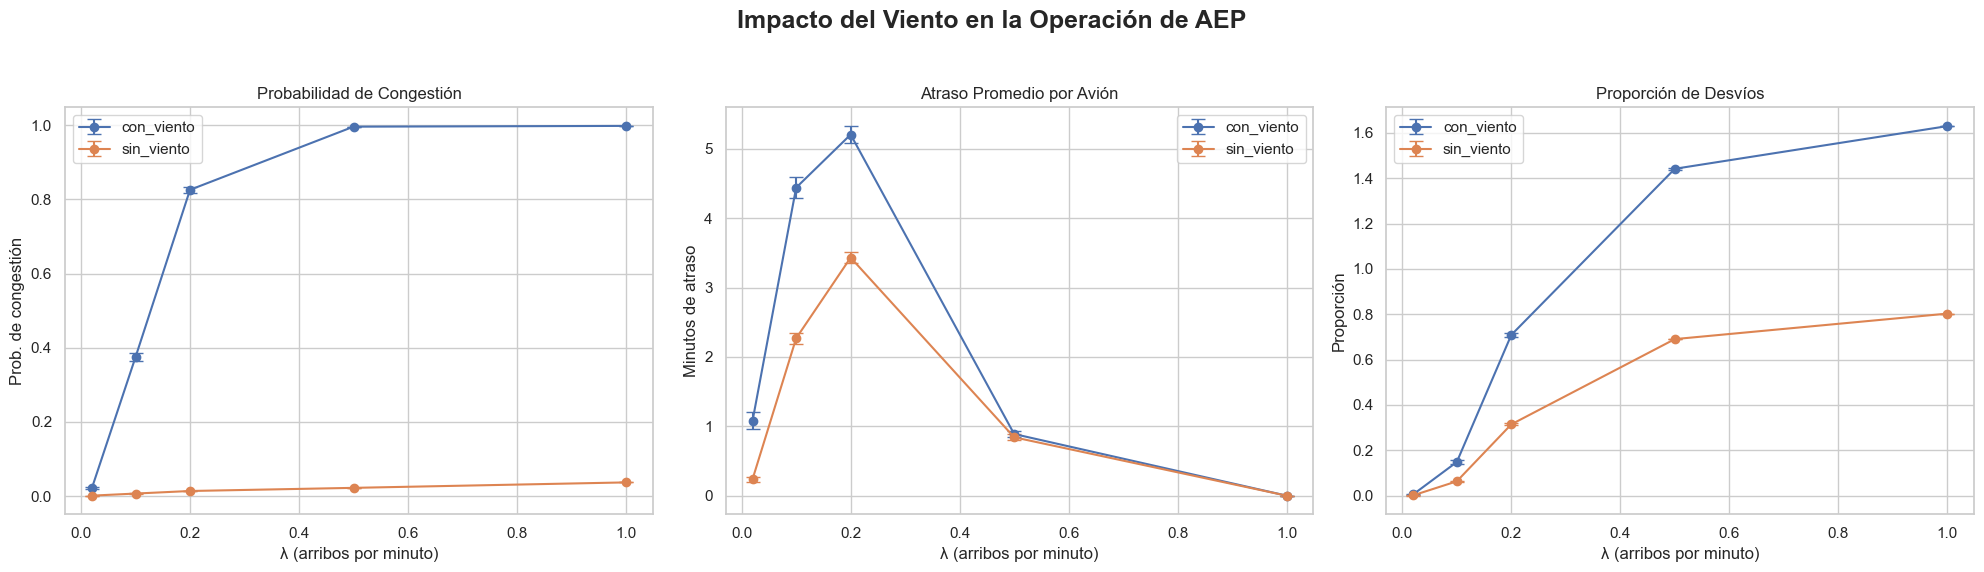

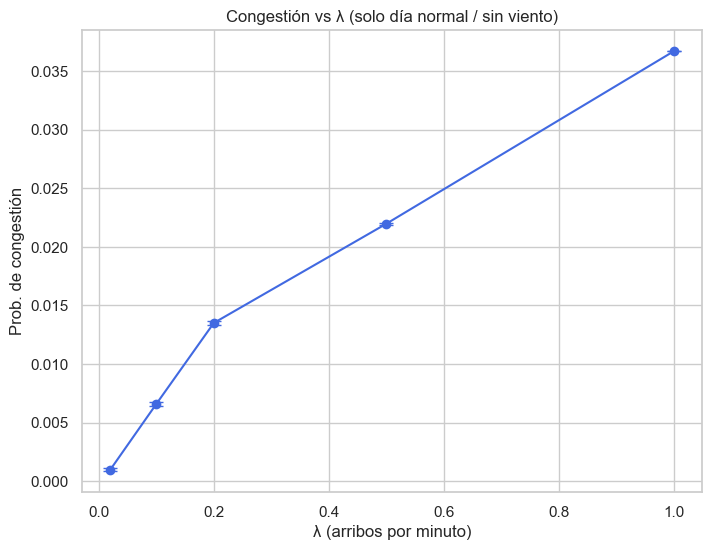

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from main import Simulador   # tu clase base (sin viento)

# =========================
# Configuración
# =========================
LAMBDAS = [0.02, 0.1, 0.2, 0.5, 1.0]
N_SIM = 50

# =========================
# Ej4 - sin viento
# =========================
def correr_montecarlo_sin_viento(lam, n_rep=N_SIM):
    congestion_counts, atrasos, desviados = [], [], []

    for _ in range(n_rep):
        sim = Simulador(seed=np.random.randint(0, 1_000_000))
        sim.simular_dia(lam)

        # --- congestión
        cong_eventos = sum(1 for h in sim.historial if h["estado"] in ("AJUSTANDO", "REGRESANDO"))
        cong = cong_eventos / max(1, len(sim.historial))
        congestion_counts.append(cong)

        # --- atraso promedio
        atrasos_rep = [a.retraso for a in sim.finalizados if a.estado == "ATERRIZADO"]
        atrasos.append(np.mean(atrasos_rep) if atrasos_rep else 0)

        # --- desvíos
        desv = sum(1 for a in sim.aviones.values() if a.estado == "DESVIADO") / max(1, len(sim.aviones))
        desviados.append(desv)

    return {
        "cong_mean": np.mean(congestion_counts),
        "cong_std": np.std(congestion_counts) / np.sqrt(n_rep),
        "delay_mean": np.mean(atrasos),
        "delay_std": np.std(atrasos) / np.sqrt(n_rep),
        "div_mean": np.mean(desviados),
        "div_std": np.std(desviados) / np.sqrt(n_rep),
    }

# =========================
# Ej5 - con viento
# =========================
def correr_montecarlo_con_viento(lam, n_rep=N_SIM):
    congestion_counts, atrasos, desviados = [], [], []

    for _ in range(n_rep):
        r = simular_una_corrida_viento(lam)

        # calcular congestión aunque no exista 'congestion_prob'
        if "congestion_prob" in r:
            cong = r["congestion_prob"]
        else:
            cong = r["congestion_ticks"] / max(1, 1080)  # o tiempo_total - warmup
        congestion_counts.append(cong)

        # atraso promedio
        delay = r["total_delay_min"] / max(1, r["landed_planes"])
        atrasos.append(delay)

        # desvíos
        desv = r["diversions"] / max(1, r["total_planes"])
        desviados.append(desv)

    return {
        "cong_mean": np.mean(congestion_counts),
        "cong_std": np.std(congestion_counts) / np.sqrt(n_rep),
        "delay_mean": np.mean(atrasos),
        "delay_std": np.std(atrasos) / np.sqrt(n_rep),
        "div_mean": np.mean(desviados),
        "div_std": np.std(desviados) / np.sqrt(n_rep),
    }



# =========================
# Bucle experimental
# =========================
resultados = []
for lam in LAMBDAS:
    r4 = correr_montecarlo_sin_viento(lam)
    r4["lambda"] = lam
    r4["tipo"] = "sin_viento"
    resultados.append(r4)

    r5 = correr_montecarlo_con_viento(lam)
    r5["lambda"] = lam
    r5["tipo"] = "con_viento"
    resultados.append(r5)

df = pd.DataFrame(resultados)

# =========================
# Panel comparativo
# =========================
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)
fig.suptitle('Impacto del Viento en la Operación de AEP', fontsize=18, weight='bold')

# Panel 1: Congestión
ax1 = axes[0]
for tipo, df_sub in df.groupby("tipo"):
    ax1.errorbar(df_sub["lambda"], df_sub["cong_mean"], yerr=df_sub["cong_std"],
                 fmt="o-", capsize=5, label=tipo)
ax1.set_title("Probabilidad de Congestión")
ax1.set_ylabel("Prob. de congestión")
ax1.set_xlabel("λ (arribos por minuto)")


# Panel 2: Atraso
ax2 = axes[1]
for tipo, df_sub in df.groupby("tipo"):
    ax2.errorbar(df_sub["lambda"], df_sub["delay_mean"], yerr=df_sub["delay_std"],
                 fmt="o-", capsize=5, label=tipo)
ax2.set_title("Atraso Promedio por Avión")
ax2.set_ylabel("Minutos de atraso")

# Panel 3: Desvíos
ax3 = axes[2]
for tipo, df_sub in df.groupby("tipo"):
    ax3.errorbar(df_sub["lambda"], df_sub["div_mean"], yerr=df_sub["div_std"],
                 fmt="o-", capsize=5, label=tipo)
ax3.set_title("Proporción de Desvíos")
ax3.set_ylabel("Proporción")

for ax in axes:
    ax.set_xlabel("λ (arribos por minuto)")
    ax.grid(True)
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ======================
# Congestión SOLO sin viento
# ======================
df_sin = df[df["tipo"] == "sin_viento"]

plt.figure(figsize=(8,6))
plt.errorbar(
    df_sin["lambda"],
    df_sin["cong_mean"],
    yerr=df_sin["cong_std"],
    fmt='-o',
    color="royalblue",
    capsize=5
)
plt.xlabel("λ (arribos por minuto)")
plt.ylabel("Prob. de congestión")
plt.title("Congestión vs λ (solo día normal / sin viento)")
plt.grid(True)
plt.show()
